In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap
import matplotlib.patches as pltpat
import math
import time
import random
from matplotlib import cm
from collections import deque

from geopy.distance import lonlat, distance

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT
show_animation = False

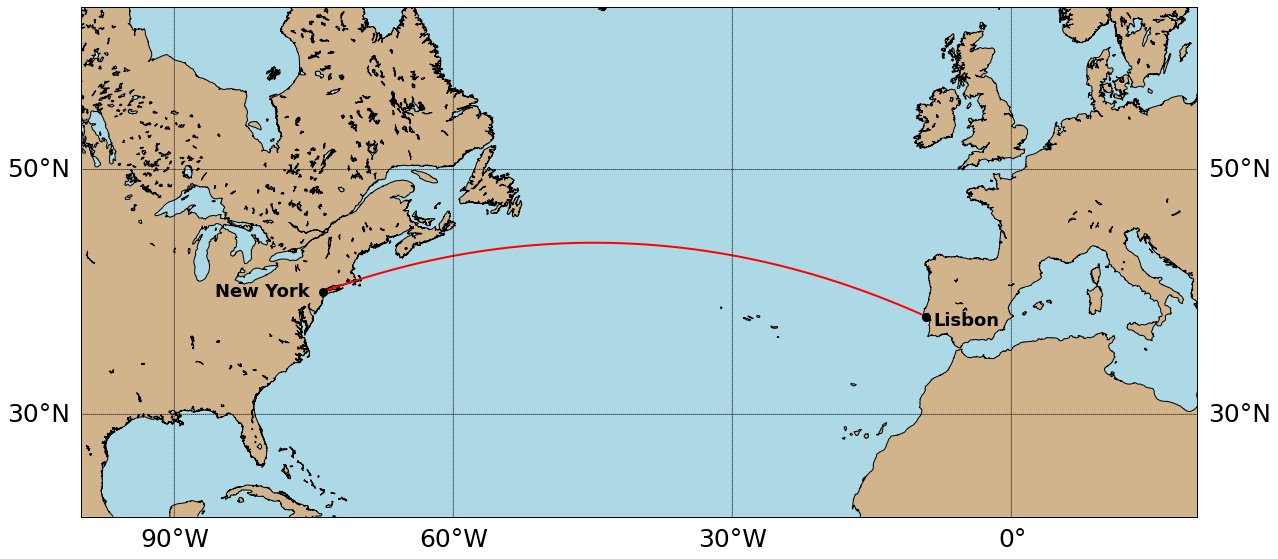

In [202]:
# create new figure, axes instances.
plt.figure(1, figsize=(20, 15))
# setup mercator map projection.
m = Basemap(llcrnrlon=-100.,llcrnrlat=20.,urcrnrlon=20.,urcrnrlat=60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='i',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98 #73.98  , 40.78
# lonlat, lonlon are lat/lon of London.
lonlat = 38.71; lonlon = -9.13  #  51.53;  0.08
# draw great circle route between NY and London

nx, ny = m(nylon, nylat)
lx, ly = m(lonlon, lonlat)

plt.text(nx-150000, ny-100000, 'New York',fontsize=18,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(lx+80000, ly-150000, 'Lisbon',fontsize=18, fontweight='bold',
                    ha='left',va='bottom',color='k')

m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='red')
plt.plot(nx, ny, "ok", markersize=8)
plt.plot(lx, ly, "ok", markersize=8)
m.drawcoastlines()
m.fillcontinents(color='tan',lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1], fontsize=25)
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1], fontsize=25)
# ax.set_title('Great Circle from New York to Lisboa')
# m.drawmapscale(-70, 20, -3.25, 39.5, 500, barstyle='fancy')
# m.drawmapscale(-0., 35.8, -3.25, 39.5, 500, fontsize = 14)
# plt.savefig('weatherroute.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ds = xr.tutorial.load_dataset("Italy_12km_WRF_WAM_220321-00.grib", engine="cfgrib")

In [3]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# 2021-07-18, 2021-08-23, 2021-08-24, 2021-09-10, 2021-09-18, 
# 2021-10-11, 2021-10-22, 2021-10-27, 2021-10-31, 2021-11-05, 2021-12-18, 2021-03-07
july18 = data.sel(time='2021-07-18') 
wave = july18.variables['VHM0'][:]

wave[0]

<xarray.Variable (latitude: 47, longitude: 62)>
array([[0.851, 0.856, 0.862, ..., 1.575, 1.571, 1.564],
       [0.808, 0.801, 0.795, ..., 1.583, 1.576, 1.565],
       [0.743, 0.708, 0.677, ..., 1.589, 1.579, 1.565],
       ...,
       [0.478, 0.475, 0.472, ...,   nan,   nan,   nan],
       [0.484, 0.483, 0.481, ...,   nan,   nan,   nan],
       [0.489, 0.488, 0.487, ...,   nan,   nan,   nan]], dtype=float32)
Attributes:
    long_name:         Spectral significant wave height (Hm0)
    standard_name:     sea_surface_wave_significant_height
    units:             m
    type_of_analysis:  spectral analysis
    WMO:               100
    _ChunkSizes:       [   1  380 1307]

In [4]:
# general basemap of Italy configuration space
# mp = Basemap(projection='merc',
#              llcrnrlon=6.42,  
#              llcrnrlat=40.58, 
#              urcrnrlon=15.13, 
#              urcrnrlat=45.5488,  
#              resolution='f') # f

# x_min, y_min = mp(lons.values[0], lats.values[0]) 
# x_max, y_max = mp(lons.values[-1], lats.values[-1])   
# lon, lat = np.meshgrid(lons, lats)   # 62 x 47
# x, y = mp(lon, lat)
# basemap for zoom plots
mp2 = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='f') # f

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp2(lon, lat)



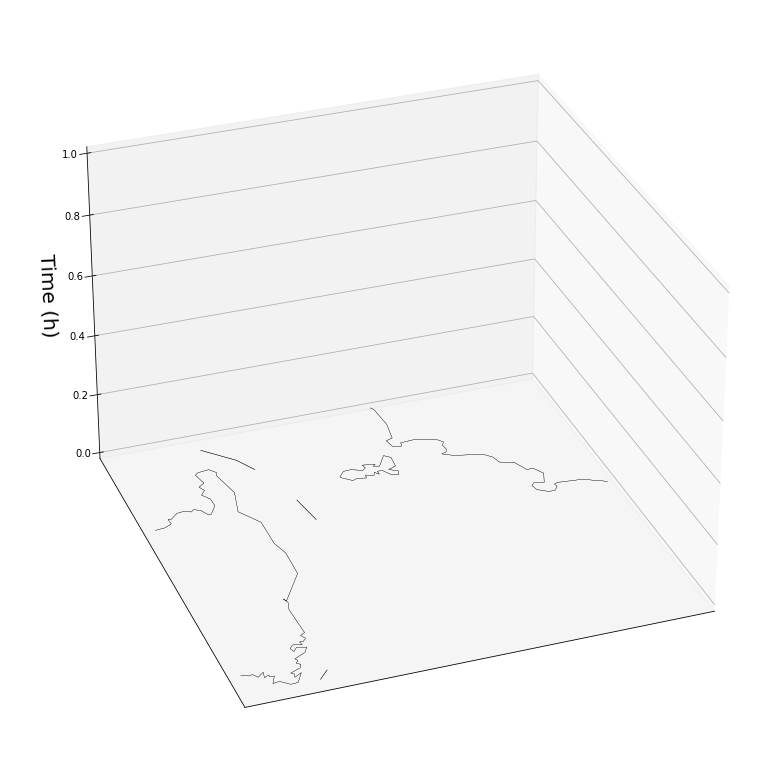

In [72]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,14))
ax = fig.gca(projection='3d')
mp2 = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='i',fix_aspect=False, ax=ax) # f
lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp2(lon, lat)
ax.add_collection3d(mp2.drawcoastlines(linewidth=0.25))
ax.add_collection3d(mp2.drawcountries(linewidth=0.35))
ax.view_init(azim=250, elev=30)
ax.set_zlabel('Time (h)', labelpad=10, fontsize=20)
meridians = np.arange(lons.values[0],lons.values[-1]+0.5,0.5) #longitudes
parallels = np.arange(lats.values[0],lats.values[-1]+0.5,0.5) #latitudes
# ax.set_yticks(parallels)
# ax.set_yticklabels(parallels)
# ax.set_xticks(meridians)
# ax.set_xticklabels(meridians)
# x = np.linspace(0, 1, 100)
# X, Y = np.meshgrid(x, x)
# Z = np.sin(X)*np.sin(Y)

# levels = np.linspace(-1, 1, 40)

# ax.contourf(x, y, cost[0], zdir='z', levels=.1*levels)
# ax.contourf(X, Y, 3+.1*np.sin(5*X)*np.sin(8*Y), zdir='z', levels=3+.1*levels)
# ax.contourf(X, Y, 7+.1*np.sin(7*X)*np.sin(3*Y), zdir='z', levels=7+.1*levels)

# ax.legend()
# ax.set_xlim3d(0, 1)
# ax.set_ylim3d(0, 1)
# ax.set_zlim3d(0, 10)

plt.show()

In [136]:
# import visvis as vv
# # vv.use('wx')

# import numpy as np
# from matplotlib.image import imread
# from matplotlib.cbook import get_sample_data

# imgdata = imread(get_sample_data('loc+2impr.png'))

# nr, nc = imgdata.shape[:2]
# x,y = np.mgrid[:nr, :nc]
# z = np.ones((nr, nc))

# for ii in xrange(5):
#     vv.functions.surf(x, y, z*ii*100, imgdata, aa=3)

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
import cv2


img = cv2.imread('cost0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x, y = np.ogrid[0:img.shape[0], 0:img.shape[1]]
img = img.astype('float32')/255
fig = plt.Figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x, y, np.atleast_2d(0), rstride=4, cstride=4, facecolors=img)
img = cv2.imread('cost1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x, y = np.ogrid[0:img.shape[0], 0:img.shape[1]]
img = img.astype('float32')/255
ax.plot_surface(x, y, np.atleast_2d(50), rstride=4, cstride=4, facecolors=img)
img = cv2.imread('cost2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x, y = np.ogrid[0:img.shape[0], 0:img.shape[1]]
img = img.astype('float32')/255
ax.plot_surface(x, y, np.atleast_2d(100), rstride=4, cstride=4, facecolors=img)
img = cv2.imread('cost3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x, y = np.ogrid[0:img.shape[0], 0:img.shape[1]]
img = img.astype('float32')/255
ax.plot_surface(x, y, np.atleast_2d(150), rstride=4, cstride=4, facecolors=img)
img = cv2.imread('cost4.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x, y = np.ogrid[0:img.shape[0], 0:img.shape[1]]
img = img.astype('float32')/255
ax.plot_surface(x, y, np.atleast_2d(200), rstride=4, cstride=4, facecolors=img)
# ax.plot_surface(x, y, np.atleast_2d(15), rstride=20, cstride=20, facecolors=img)
# ax.plot_surface(x, y, np.atleast_2d(20), rstride=20, cstride=20, facecolors=img)
ax.set_zlabel('Time (h)', fontsize=5, labelpad=1)
ax.set_zticklabels(['$t_0$', '$t_1$', '$t_2$', '$t_3$', '$t_4$'], fontsize=5)
ax.tick_params(axis='z', which='major', pad=1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 1.3, 1.3]))
ax.view_init(elev=25, azim=330)
fig.savefig("resultsprova.png", dpi=500, bbox_inches='tight')


<ipython-input-219-e1452e483015>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(['$t_0$', '$t_1$', '$t_2$', '$t_3$', '$t_4$'], fontsize=5)


In [268]:
# 1 start and 2 goals
s1x, s1y = mp2(lons.values[12], lats.values[7])  # start
g1x, g1y = mp2(lons.values[50], lats.values[28]) # Argentario
g2x, g2y = mp2(lons.values[39], lats.values[33]) # Elba

s1x, s1y = mp(lons.values[12], lats.values[7])  # start
g1x, g1y = mp(lons.values[50], lats.values[28]) # Argentario
g2x, g2y = mp(lons.values[39], lats.values[33]) # Elba

In [6]:
l = 24
li = 0   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    5   
le = 15  # 15  18    18  17    15  - 17   23   12   12   15   18   15   
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i]))

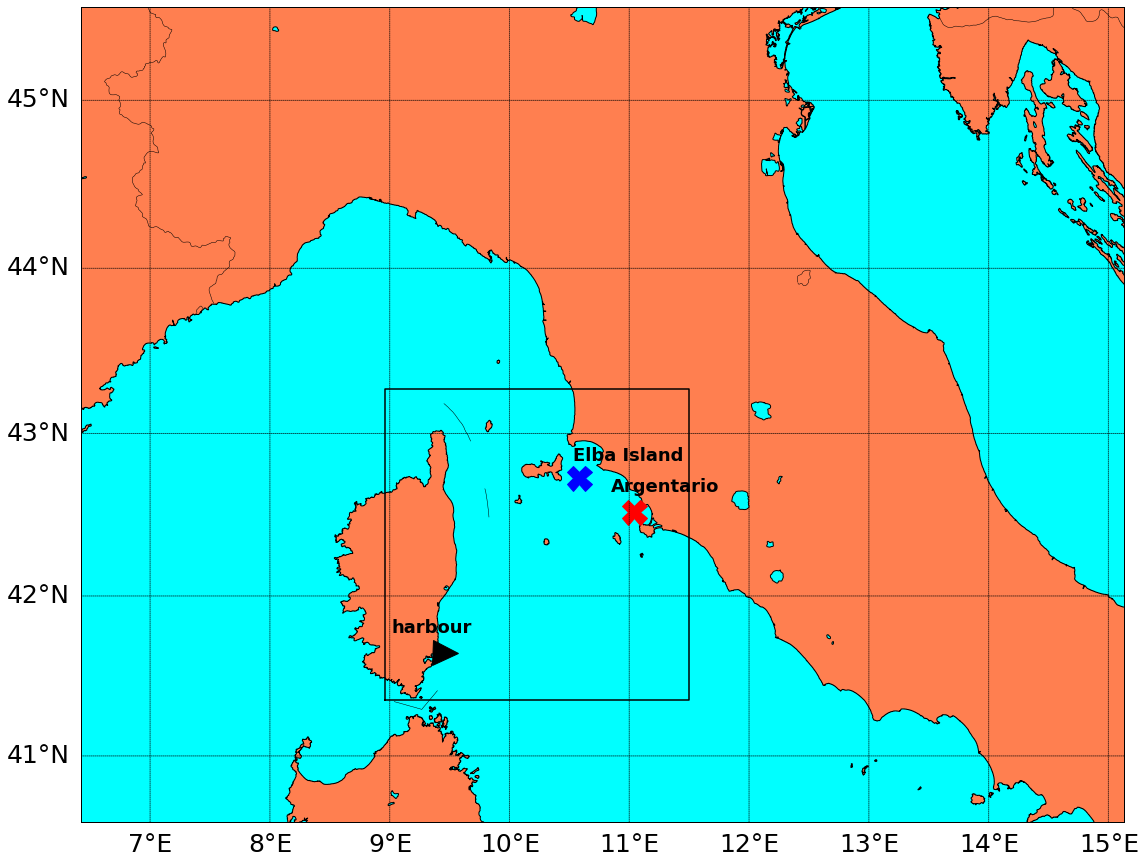

In [252]:
plt.figure(1, figsize=(20, 15))
# c_scheme = mp.pcolor(x, y, wave[5], cmap='jet')
mp.fillcontinents(color='coral',lake_color='aqua')
mp.plot(s1x, s1y, ">k", markersize=25)
plt.plot(g1x, g1y, "Xr", markersize=25)
plt.plot(g2x, g2y, "Xb", markersize=25)
plt.text(s1x+25000, s1y+15000, 'harbour',fontsize=18,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x-22000, g1y+15000, 'Argentario',fontsize=18, fontweight='bold',
                    ha='left',va='bottom',color='k')
plt.text(g2x-6000, g2y+12000, 'Elba Island',fontsize=18, fontweight='bold',
                    ha='left',va='bottom',color='k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.drawmapboundary(fill_color='aqua')
# cbar = mp.colorbar(c_scheme, location='right', pad='10%')
# cbar.set_label('$H_{m0}$ $[m]$')
mp.drawmeridians(np.arange(6,16,1.0),labels=[0,0,0,1], fontsize=25) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0], fontsize=25) #latitudes
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# plt.savefig('conf_space2223.png', dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-16-551a5c9398b0>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp2.pcolor(x, y, cost15, cmap=ListedColormap(['white', 'red']))


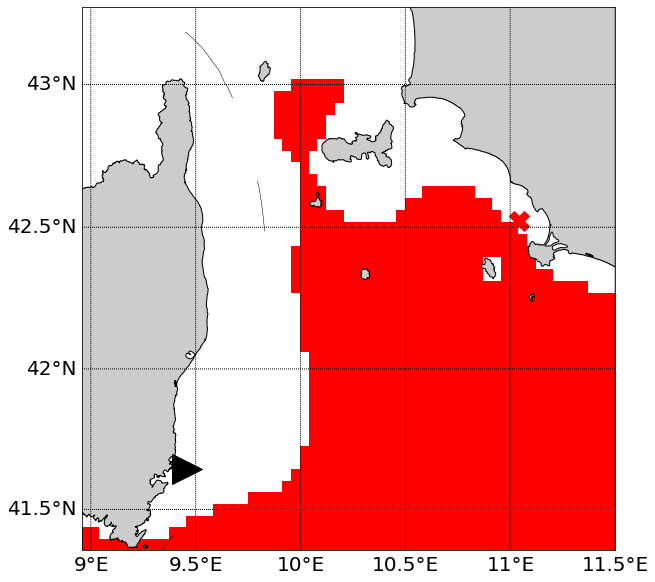

In [16]:
plt.figure(1, figsize=(15, 10))
mp2.plot(sx_init, sy_init, ">k", markersize=30)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
mp2.pcolor(x, y, cost15, cmap=ListedColormap(['white', 'red']))
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
mp2.drawmeridians(np.arange(6,15,0.5),labels=[0,0,0,1], fontsize=20) #longitudes
mp2.drawparallels(np.arange(40,46,0.5),labels=[1,0,0,0], fontsize=20) #latitudes
plt.savefig("sumpic.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
cost15 = 0
for i in range(len(cost)):
    cost15 += cost[i]
cost15 = 100*(np.array(cost15)>=100)

contour15 = np.logical_xor(cost15,binary_erosion(cost15))

<ipython-input-22-0ee2d7c5f5db>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  scheme = mp.pcolor(x, y, wave[11], cmap='jet')


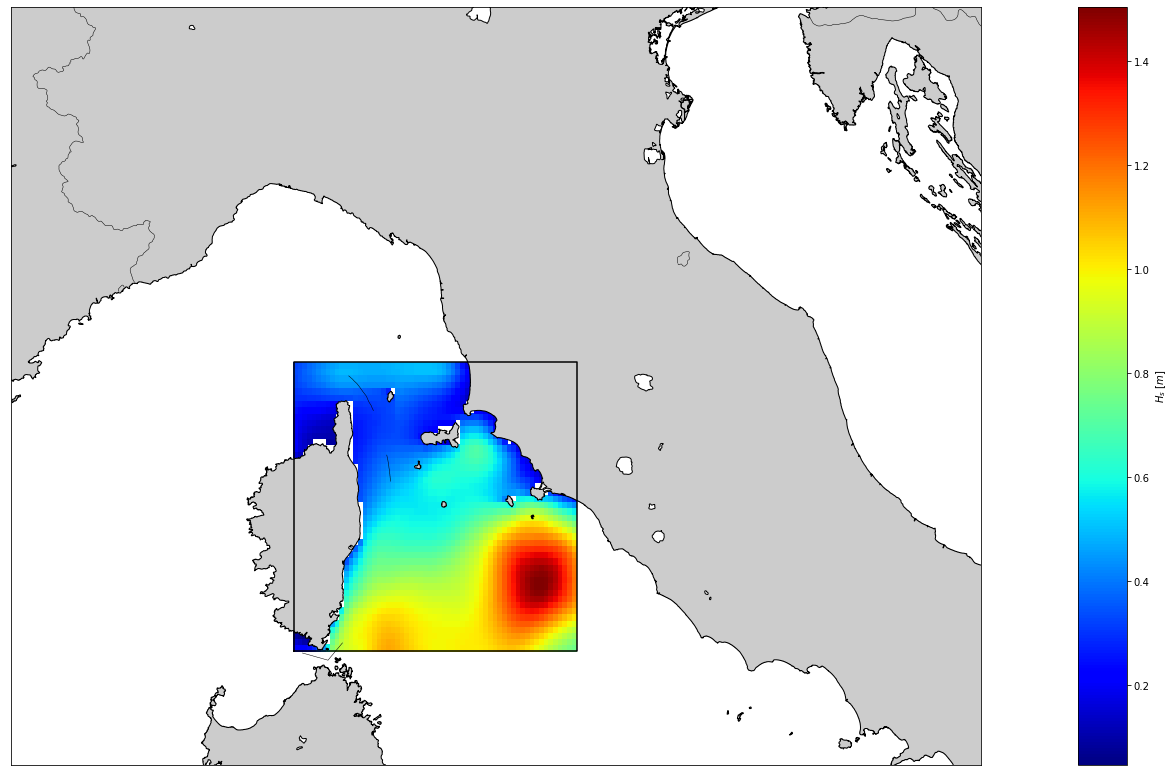

In [22]:
plt.figure(1, figsize=(20, 15))
# scheme = mp.pcolor(x, y, cost[11], cmap=ListedColormap(['white', 'red']))
scheme = mp.pcolor(x, y, wave[11], cmap='jet')
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
cbar = mp.colorbar(scheme, location='right', pad='10%')
# plt.clim(0, 1)
cbar.set_label('$H_s$ $[m]$')
# mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
# mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
# plt.savefig("dynobscost.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-311-2c7e43486b2a>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, contour15,cmap=ListedColormap(['white', 'red']))


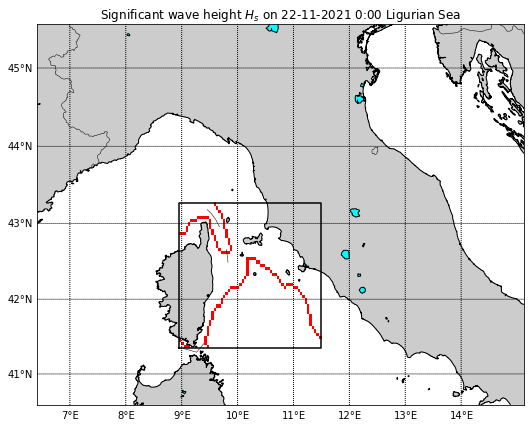

In [311]:
plt.figure(1, figsize=(10, 7))
mp.pcolor(x, y, contour15,cmap=ListedColormap(['white', 'red']))
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()

In [330]:
oxland, oyland = [], []
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []

oxmeteo, oymeteo = [], []     # all meteo points
x_obsm, y_obsm = [], []       # contour meteo points
oxmeteo_, oymeteo_ = [], []   # all meteo points
x_obsm_, y_obsm_ = [], []     # contour meteo points


for k in np.arange(0,47,1):
    for j in np.arange(0,62,1):
        if contour15[k][j]:
            #if lats.values[k] < 42.6:
#             if 9.45< lons.values[j]< 9.46 and 41.64 < lats.values[k] < 41.7:
#                 continue
            x_obsm.append(lons.values[j])
            y_obsm.append(lats.values[k])
x_obsm_, y_obsm_ = mp(x_obsm, y_obsm)       # meteo contour points

# land is always static    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]:
#                     if lons_mask.values[j] > 9.8:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
                    
                        
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points

ox_a_list = []
oy_a_list = []
ox_a_list.extend(x_obsm)
oy_a_list.extend(y_obsm)
# ox_a_list.extend(x_obsl)
# oy_a_list.extend(y_obsl)

In [9]:
xspace = lons.values
yspace = lats.values

sx = xspace[12]   # 9.41        # [12]
sy = yspace[7]    # 43.104168   # [6]
gx = xspace[50]   # 11.291668    39
gy = yspace[28]   # 42.520832    33

sx_init, sy_init = mp2(sx, sy)
gx_a, gy_a = mp2(gx, gy)

In [332]:
grid_size = 0.04166
robot_radius = grid_size

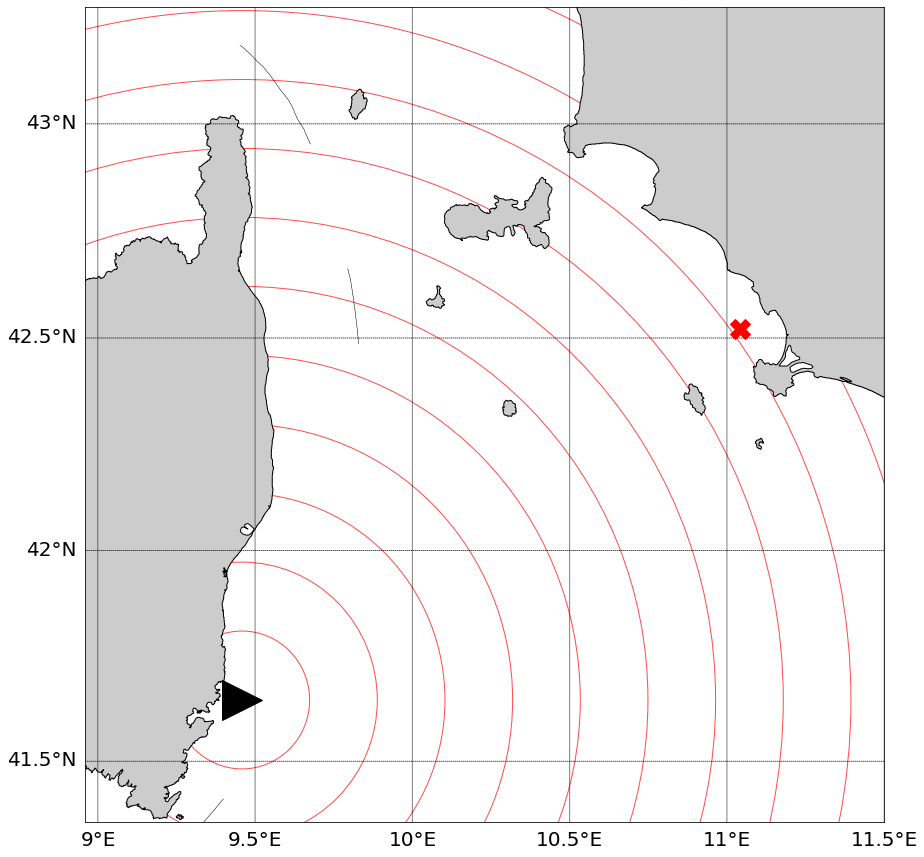

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp2.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
# plt.scatter(x_obsl_, y_obsl_, color="peru", linewidth=10)
# plt.scatter(x_obsm_, y_obsm_, linewidth=10, color="dodgerblue")
# plt.color(xs_, )
hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp2(lons.values[-1],lats.values[-1])[1])
ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp2(lons.values[-1],lats.values[-1])[0])

for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
                                color='red', alpha=0.7, fill = False))
# plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1], fontsize=20) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0], fontsize=20) #latitudes
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig("temporalband.png", dpi=300, bbox_inches='tight')
plt.show()

In [338]:
start_time = time.time()
a_star = AStarPlanner(ox_a_list, oy_a_list, grid_size, robot_radius, xspace[0], yspace[0], xspace[-1], yspace[-1])
rx2, ry2 = a_star.planning(sx, sy, gx, gy)
print("Computational time is {}".format(time.time() - start_time))
rx2 = list(reversed(rx2))
ry2 = list(reversed(ry2))

min_x: 8.958333969116211°
min_y: 41.35416793823242°
max_x: 11.500000953674316°
max_y: 43.27083206176758°
x_width: 62
y_width: 47
Find goal
Computational time is 4.667338132858276


In [337]:
import math

import matplotlib.pyplot as plt

show_animation = False


class AStarPlanner:

    def __init__(self, ox, oy, resolution, rr, xm, ym, xM, yM):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = xm, ym
        self.max_x, self.max_y = xM, yM
        self.obstacle_map = None
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy)

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, gx, gy):
        """
        A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """
        # k = 1
        start_node = self.Node(self.calc_xy_index(sx, self.min_x), self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x), self.calc_xy_index(gy, self.min_y), 0.0, -1)
        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node
        while 1:
            if len(open_set) == 0:
                print("Open set is empty..")
                break
            # find the index with smallest (cost+distance from goal)
            c_id = min(open_set, key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node, open_set[o]))
            current = open_set[c_id]  # take that point as current point

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(self.calc_grid_position(current.x, self.min_x),
                         self.calc_grid_position(current.y, self.min_y), "xc")  # x color cyan
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect('key_release_event',
                                             lambda event: [exit(
                                                 0) if event.key == 'escape' else None])
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node

        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        # distance(lonlat(*(n1.x,n1.y)), lonlat(*(n2.x,n2.y))).km
        d = w * distance(lonlat(*(n1.x,n1.y)), lonlat(*(n2.x,n2.y))).km #math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.y][node.x]:  #
            return False

        return True

    def calc_obstacle_map(self, ox, oy):
        print("min_x: {}°".format(self.min_x))
        print("min_y: {}°".format(self.min_y))
        print("max_x: {}°".format(self.max_x))
        print("max_y: {}°".format(self.max_y))
        # self.x_width = round((self.max_x - self.min_x) / self.resolution)
        # self.y_width = round((self.max_y - self.min_y) / self.resolution)
        self.x_width = 62
        self.y_width = 47
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = [[False for _ in range(self.x_width)]
                             for _ in range(self.y_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                # for q, _ in enumerate(ox):
                #    d = math.hypot(ox[q] - x, oy[q] - y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[iy][ix] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion


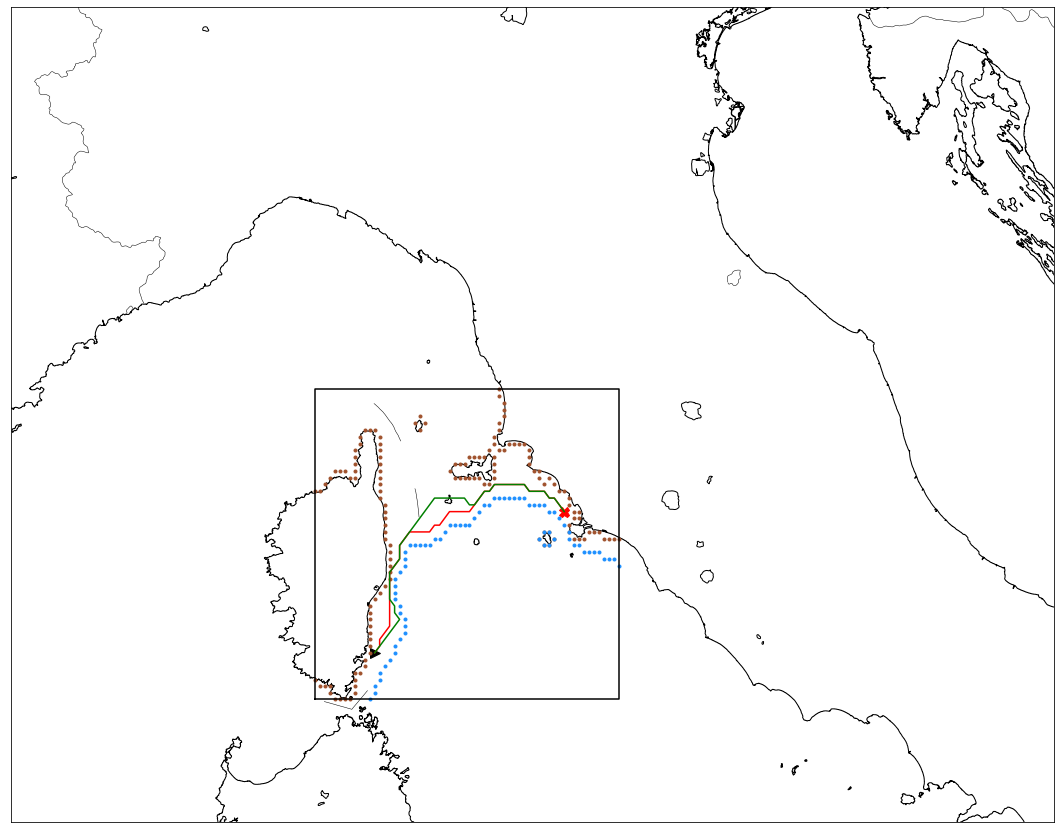

In [339]:
rx_, ry_ = mp(rx, ry)
rx_2, ry_2 = mp(rx2, ry2)
plt.figure(1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
mp.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot(x_obsm_, y_obsm_, '.', color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(rx_, ry_, '-r')
mp.plot(rx_2, ry_2, '-g')
#mp.plot(loaded_list[3], loaded_list2[3], '-b')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [336]:
path_dist = 0
for i in range(len(rx)-1):
    path_dist += distance(lonlat(*(rx[i],ry[i])), lonlat(*(rx[i+1],ry[i+1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  12.3898 hours


In [340]:
path_dist2 = 0
for i in range(len(rx2)-1):
    path_dist2 += distance(lonlat(*(rx2[i],ry2[i])), lonlat(*(rx2[i+1],ry2[i+1]))).km
print("Travel time = ", str(round(path_dist2/18,4)), "hours")

Travel time =  12.901 hours


In [345]:
# p = distance(lonlat(*(sx,sy)), lonlat(*(gx,gy))).km
# print("Travel time = ", str(round(p/18,4)), "hours")

Travel time =  8.4466 hours


In [338]:
sum_pathy2.append(ry_)
sum_pathx2.append(rx_)
# sum_pathx1[-1]
len(sum_pathx2)

12

In [49]:
sum_pathx1 = [[] for i in range(5)]  # 5 for 5 day missions
sum_pathy1 = [[] for i in range(5)]
sum_pathx2 = [[] for i in range(5)]
sum_pathy2 = [[] for i in range(5)]

In [392]:
sum_pathx2[0] = rx_
sum_pathy2[0] = ry_

In [350]:
import pickle
file_name = "sum_astarx2.pkl"
open_file = open(file_name, "wb")
pickle.dump(sum_pathx2, open_file)
open_file.close()
# file_name = "sum_astary1.pkl"
# open_file = open(file_name, "rb")
# sum_pathy1 = pickle.load(open_file)
# open_file.close()



## RRT

In [774]:
x_obsl, y_obsl = [], []
Cspacex, Cspacey = [], []

x_obsm, y_obsm = [], []       # contour meteo points


for k in np.arange(0,47,1):
    for j in np.arange(0,62,1):
        if contour15[k][j]:
#             if 9.40< lons.values[j]< 9.46 and 41.62 < lats.values[k] < 41.7:
#                 continue
            x_obsm.append(lons.values[j])
            y_obsm.append(lats.values[k])

x_obsm_, y_obsm_ = mp(x_obsm, y_obsm)       # meteo contour points
    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    if lons_mask.values[j] > 9.8:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
                if mask.values[k][j] == 1:
                    Cspacex.append(lons_mask.values[j])
                    Cspacey.append(lats_mask.values[k])
                    
Cspacex_, Cspacey_ = mp(Cspacex, Cspacey)                   
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points

In [775]:
mp(sx,sy)

(337847.16373075347, 157309.51157040708)

In [794]:
sx = xspace[12]  
sy = yspace[7] 
gx = xspace[39]   # 50  39
gy = yspace[33]   # 28  33
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)
grid_size = 4500 #  

obstacle_list_ = [[] for i in range(2)]
for i in range(2): # just not to modify the algorithm of RRT*
    for j, _ in enumerate(x_obsm_):
        obstacle_list_[i].append([x_obsm_[j], y_obsm_[j], grid_size])
#     for k, _ in enumerate(x_obsl_):
#         obstacle_list_[i].append([x_obsl_[k], y_obsl_[k], grid_size])   
# obstacle_list_[0].append([347000,157000,4500])
# obstacle_list_[0].append([345000,163000,4500])
# obstacle_list_[0].append([340000,151000,4500])

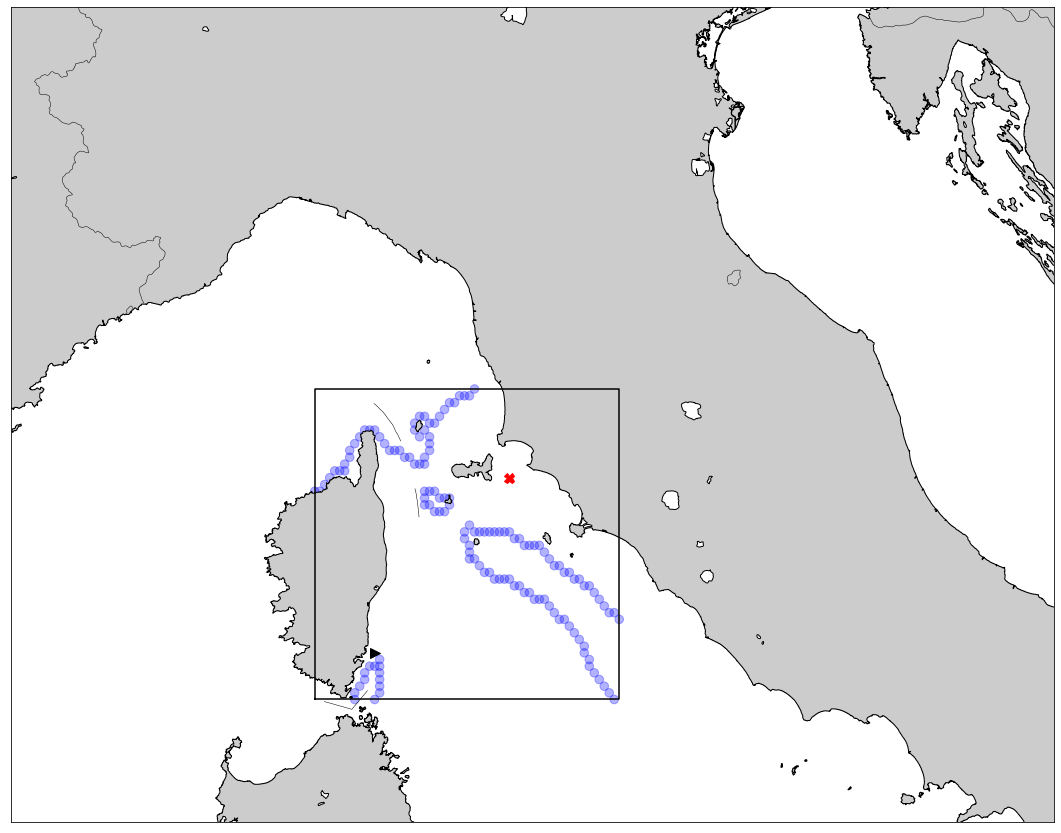

In [795]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
# plt.plot(a1, b1, ".r", markersize=5)
for i in range(len(obstacle_list_[0])):
    ax.add_patch(plt.Circle(xy=(obstacle_list_[0][i][0], obstacle_list_[0][i][1]), radius=4000,
                            color='b', alpha=0.3))
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-')
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [796]:
try:
    from rrt_netcdf import RRT
except ImportError:
    raise

show_animation = False


class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0  # taking into account the cost

    def __init__(self,
                 start,
                 goal,
                 obstacle_list,
                 rand_area,
                 c_spacex,
                 c_spacey,
                 k,
                 connect_circle_dist,
                 expand_dis,
                 speed,
                 path_resolution,
                 goal_sample_rate,
                 max_iter=3000,
                 # RRT* parameter: planning constant for the recomputing of the cost
                 search_until_max_iter=False):
        """
        Setting Parameter

        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]

        """
        super().__init__(start, goal, obstacle_list, rand_area, c_spacex, c_spacey, k, expand_dis, speed, path_resolution,
                         goal_sample_rate, max_iter)
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter

    def planning(self, animation=True):
        """
        rrt star path planning

        animation: flag for animation on or off .
        """
        v = 0
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)  # nearest index
            near_node = self.node_list[nearest_ind]  # nearest node of the list to the rnd point just found
            new_node = self.steer(near_node, rnd, self.expand_dis)  # at each iter new node change of expand_dis

            # adding cost from the near node and random node
            temp1 = mp(near_node.x, near_node.y, inverse=True)
            temp2 = mp(new_node.x, new_node.y, inverse=True)
            new_node.cost = near_node.cost + distance(lonlat(*temp1), lonlat(*temp2)).m

            # new_node.cost = near_node.cost + math.hypot(new_node.x-near_node.x, new_node.y-near_node.y)
            if self.check_collision(new_node, self.obstacle_list[self.k-1]):
                near_inds = self.find_near_nodes(new_node)  # now we have the indexes of nodes near new_node
                node_with_updated_parent = self.choose_parent(new_node, near_inds)  # arguments: new node and indexes
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)
            # mp(new_node.x, new_node.y, inverse=True)

            """if new_node.cost/5 > 3600*self.k:  # comment if global planning
                self.k += 1"""

                # if self.k > 14:
                #    self.k = 14

            if animation:
                v = self.draw_graph(self.obstacle_list[self.k-1], v, rnd)

            if (not self.search_until_max_iter) and new_node:  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index), new_node.cost, i

        print("reached max iteration")

        last_index = self.search_best_goal_node()   # if I want to search until reached max iteration
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and the tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node

            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:  # in a for loop
            near_node = self.node_list[i]  # the near node is each of the list with the corresponding list
            t_node = self.steer(near_node, new_node)  # it finds the node attached to new_node and define parent near_n
            if t_node and self.check_collision(t_node, self.obstacle_list[self.k-1]):
                costs.append(self.calc_new_cost(near_node, new_node))  # the function calc the cost as a distance
            else:  # costs is a list
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]  # find the index of near node (in the ball) with min cost
        new_node = self.steer(self.node_list[min_ind], new_node)  # segment between the min cost node and new node
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        #  compute the distance of each node from the goal
        dist_to_goal_list = [self.calc_dist_to_goal(n.x, n.y) for n in self.node_list]
        #  if the distance if smaller than expand dis -> add the relative index to the goal_inds list
        goal_inds = [dist_to_goal_list.index(i) for i in dist_to_goal_list if i <= self.expand_dis]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(t_node, self.obstacle_list[self.k-1]):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
        for i in safe_goal_inds:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the tree that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
        # if expand_dist exists, search vertices in a range no more than expand_dist
        # if hasattr(self, 'expand_dis'):
        #    r = max(r, self.expand_dis)
        dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
                     for node in self.node_list]  # compute distance of each node from the new_node
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds  # returns the index list of those points with a distance smaller than the ball radius

    def rewire(self, new_node, near_inds):
        """
            For each node in near_inds, this will check if it is cheaper to
            arrive to them from new_node.
            In such a case, this will re-assign the parent of the nodes in
            near_inds to new_node.
            Parameters:
            ----------
                new_node, Node
                    Node randomly added which can be joined to the tree

                near_inds, list of uints
                    A list of indices of the self.new_node which contains
                    nodes within a circle of a given radius.
            Remark: parent is designated in choose_parent.

        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            # calc the cost as distance from node with new parent and nodes in the ball
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(edge_node, self.obstacle_list[self.k-1])
            improved_cost = near_node.cost > edge_node.cost  # can be True or False

            if no_collision and improved_cost:  # if True change near node with edge node
                near_node.x = edge_node.x
                near_node.y = edge_node.y
                near_node.cost = edge_node.cost
                near_node.path_x = edge_node.path_x
                near_node.path_y = edge_node.path_y
                near_node.parent = edge_node.parent
                self.propagate_cost_to_leaves(new_node)

    def calc_new_cost(self, from_node, to_node):
        #d, _ = self.calc_distance_and_angle(from_node, to_node)
        temp1 = mp(from_node.x, from_node.y, inverse=True)
        temp2 = mp(to_node.x, to_node.y, inverse=True)
        d = distance(lonlat(*temp1), lonlat(*temp2)).m
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):  # a recursive way to compute the cost of the path till the start

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

In [801]:
rrt_star = RRTStar(
            start=[sx_init, sy_init],
            goal=[gx_a, gy_a],
            rand_area=[x_min, x_max, y_min, y_max],
            obstacle_list=obstacle_list_,
            c_spacex = Cspacex_,
            c_spacey = Cspacey_,
            k = 1,
            speed = 5,
            path_resolution=4500.0,
            connect_circle_dist=150000,
            goal_sample_rate=15,
            expand_dis=4500)

In [802]:
#%matplotlib
start_time = time.time()
path_star, cost_tot, iter_tot = rrt_star.planning(animation=show_animation)
path_star = list(reversed(path_star))
end_time = time.time()
if path_star is None:
    print("Cannot find path")
else:
    print("Found path!!")

print("The computational time is " + str(round(end_time - start_time, 4)) + " seconds")
print("Travel time = ", str(round(cost_tot/5/3600,4)), "hours")

Found path!!
The computational time is 3.651 seconds
Travel time =  8.5508 hours


In [803]:
path_starcoord = np.zeros_like(path_star)
for i in range(len(path_star)):
    path_starcoord[i][0], path_starcoord[i][1]  = mp(path_star[i][0], path_star[i][1], inverse=True)

path_dist = 0
for i in range(len(path_starcoord)-1):
    path_dist += distance(lonlat(*(path_starcoord[i][0],path_starcoord[i][1])), 
                          lonlat(*(path_starcoord[i+1][0],path_starcoord[i+1][1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  8.5442 hours


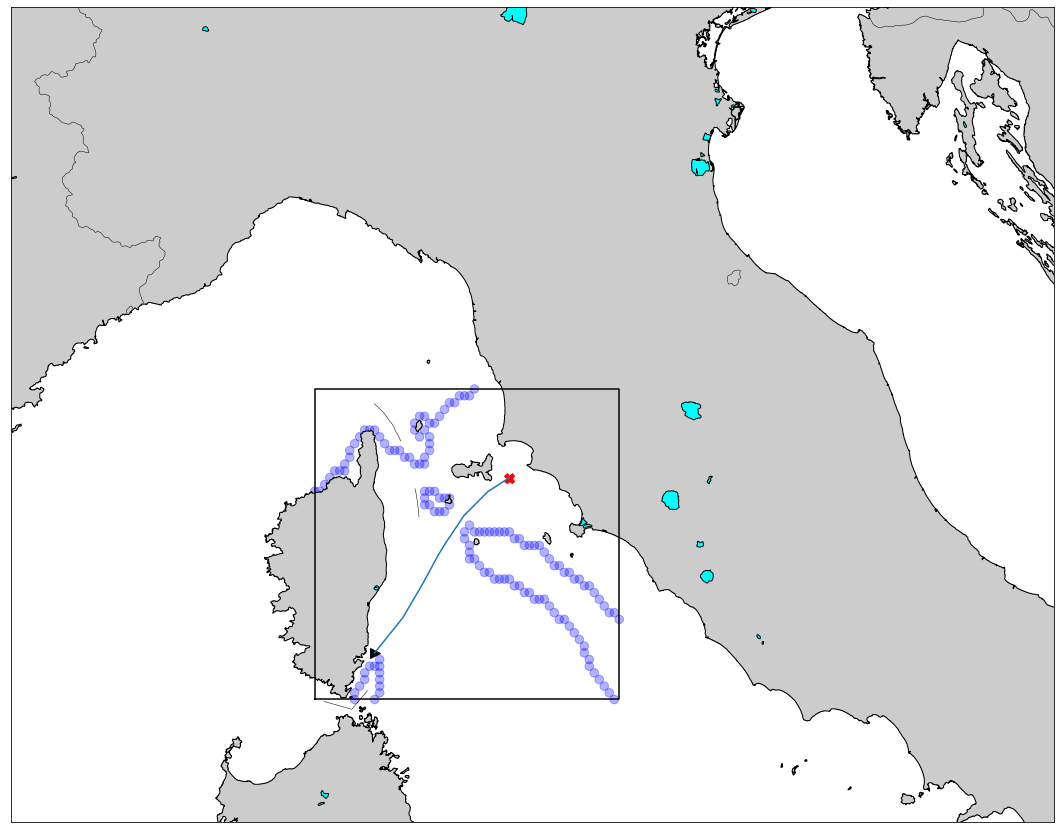

In [804]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
for i in range(len(obstacle_list_[0])):
    ax.add_patch(plt.Circle(xy=(obstacle_list_[0][i][0], obstacle_list_[0][i][1]), radius=4000,
                            color='b', alpha=0.3))
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot([x for (x, y) in path_star], [y for (x, y) in path_star], '-',label='RRT*')
# mp.plot(rx_, ry_, '-r',label='A*')
# plt.plot(map_x_, map_y_, '.', color="dodgerblue")
# plt.plot(map_x_2, map_y_2, '.', color="sienna")
# ax.legend(prop={"size":20})
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
# plt.savefig("provarrt.png", dpi=500)
plt.show()

In [33]:
# sumpathrrt1 = [[] for i in range(5)]  # 5 for 5 day missions
# sumpathrrt2 = [[] for i in range(5)]

In [282]:
# sumpathrrt1[3] = path_star

In [793]:
# sumpathrrt2[4] = None
len(sumpathrrt1)

12

In [805]:
sumpathrrt2.append(path_star)

In [826]:
## import pickle
file_name = "sum_rrt2.pkl"
open_file = open(file_name, "wb")
pickle.dump(sumpathrrt2, open_file)
open_file.close()

# file_name = "sum_rrt1.pkl"
# open_file = open(file_name, "rb")
# sumpathrrt1 = pickle.load(open_file)
# open_file.close()


In [151]:
# from mpl_toolkits.basemap import Basemap
# from geopy.distance import lonlat, distance
# import xarray as xr

# import math
# import random

# show_animation = True


# class RRT:

#     class Node:

#         def __init__(self, x, y):
#             self.x = x
#             self.y = y
#             self.path_x = []
#             self.path_y = []
#             self.parent = None

#     class AreaBounds:

#         def __init__(self, area):
#             self.xmin = float(area[0])
#             self.xmax = float(area[1])
#             self.ymin = float(area[2])
#             self.ymax = float(area[3])

#     def __init__(self,
#                  start,
#                  goal,
#                  obstacle_list,
#                  rand_area,
#                  c_spacex,
#                  c_spacey,
#                  k,
#                  expand_dis,
#                  speed,
#                  path_resolution,  # changing path resolution reduces a lot the computation time
#                  goal_sample_rate,
#                  max_iter=2000,
#                  play_area=None
#                  ):

#         self.start = self.Node(start[0], start[1])
#         self.end = self.Node(goal[0], goal[1])
#         self.min_x_rand = rand_area[0]
#         self.max_x_rand = rand_area[1]
#         self.min_y_rand = rand_area[2]
#         self.max_y_rand = rand_area[3]
#         if play_area is not None:
#             self.play_area = self.AreaBounds(play_area)
#         else:
#             self.play_area = None
#         self.c_spacex = c_spacex
#         self.c_spacey = c_spacey
#         self.expand_dis = expand_dis
#         self.path_resolution = path_resolution
#         self.goal_sample_rate = goal_sample_rate
#         self.max_iter = max_iter
#         self.obstacle_list = obstacle_list
#         self.node_list = []
#         self.speed = speed
#         self.k = k

#     def planning(self, animation=True):
#         v = 0
#         k = 1
#         dist_tot = 0
#         self.node_list = [self.start]
#         for i in range(self.max_iter):
#             rnd_node = self.get_random_node()
#             nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
#             nearest_node = self.node_list[nearest_ind]

#             new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

#             if self.check_if_outside_play_area(new_node, self.play_area) and \
#                self.check_collision(new_node, self.obstacle_list[self.k-1]):
#                 self.node_list.append(new_node)

#             if animation and i % 5 == 0:
#                 v = self.draw_graph(self.obstacle_list[self.k-1], rnd_node, v)

#             dist_tot += self.calc_cost()
#             if dist_tot/self.speed >= 3600*k:
#                 k += 1
#                 if k > 4:
#                     k = 4
#             if self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y) <= self.expand_dis:
#                 final_node = self.steer(self.node_list[-1], self.end,
#                                         self.expand_dis)
#                 if self.check_collision(final_node, self.obstacle_list[k-1]):
#                     return self.generate_final_course(len(self.node_list) - 1), dist_tot

#             if animation and i % 5:
#                 v = self.draw_graph(self.obstacle_list[self.k-1], rnd_node, v)

#         return None  # cannot find path

#     def steer(self, from_node, to_node, extend_length=float("inf")):

#         new_node = self.Node(from_node.x, from_node.y)
#         d, theta = self.calc_distance_and_angle(new_node, to_node)
#         new_node.path_x = [new_node.x]
#         new_node.path_y = [new_node.y]

#         if extend_length > d:
#             extend_length = d

#         n_expand = math.floor(extend_length / self.path_resolution)
#         for _ in range(n_expand):
# #             new_node.x += self.path_resolution * math.cos(theta)
# #             new_node.y += self.path_resolution * math.sin(theta)
#             new_node.x += 0.05 * math.cos(theta)
#             new_node.y += 0.05 * math.sin(theta)
#             new_node.path_x.append(new_node.x)
#             new_node.path_y.append(new_node.y)
            
#         d, _ = self.calc_distance_and_angle(new_node, to_node)
#         if d <= self.path_resolution:
#             new_node.path_x.append(to_node.x)
#             new_node.path_y.append(to_node.y)
#             new_node.x = to_node.x
#             new_node.y = to_node.y
#         new_node.parent = from_node

#         return new_node

#     def generate_final_course(self, goal_ind):
#         path = [[self.end.x, self.end.y]]
#         node = self.node_list[goal_ind]
#         while node.parent is not None:
#             path.append([node.x, node.y])
#             node = node.parent
#         path.append([node.x, node.y])

#         return path

#     def calc_dist_to_goal(self, x, y):
# #         dx = x - self.end.x
# #         dy = y - self.end.y
#         return distance(lonlat(*(x, y)), lonlat(*(self.end.x, self.end.y))).m    #math.hypot(dx, dy)

# #     def calc_cost(self):
# #         a1 = mp(self.node_list[-1].x, self.node_list[-1].y, inverse=True)
# #         b1 = mp(self.node_list[-2].x, self.node_list[-2].y, inverse=True)

# #         return distance(lonlat(*a1), lonlat(*b1)).m

# #     def calc_temp_dist_from_start(self, x, y):
# #         dx = x - self.start.x
# #         dy = y - self.start.y
# #         # the distance is in meter. So distance/speed = time [seconds]
# #         return math.hypot(dx, dy) / self.speed

#     def get_random_node(self):
#         if random.randint(0, 100) > self.goal_sample_rate:
#             rnd = self.Node(
# #                 random.uniform(self.min_x_rand, self.max_x_rand),
# #                 random.uniform(self.min_y_rand, self.max_y_rand))
#             random.choice(self.c_spacex),
#             random.choice(self.c_spacey))
#         else:  # goal point sampling
#             rnd = self.Node(self.end.x, self.end.y)
#         return rnd
    
#     def draw_graph(self, rnd=None):

#         plt.clf()  # it clears the figure. In this way points do not overlap
#         # for stopping simulation with the esc key.
#         plt.gcf().canvas.mpl_connect(
#             'key_release_event',
#             lambda event: [exit(0) if event.key == 'escape' else None])
#         if rnd is not None:
#             plt.plot(rnd.x, rnd.y, "^k")
#         for node in self.node_list:
#             if node.parent:
#                 plt.plot(node.path_x, node.path_y, "-g")

#         for i in range(len(self.obstacle_list[self.k-1])):
#             plt.plot(self.obstacle_list[self.k-1][i][0], self.obstacle_list[self.k-1][i][1], ".", color='dodgerblue')


#         plt.plot([self.min_x_rand, self.max_x_rand, self.max_x_rand, self.min_x_rand, self.min_x_rand], [self.min_y_rand, self.min_y_rand, self.max_y_rand, self.max_y_rand, self.min_y_rand], "-k")
#         plt.plot(self.start.x, self.start.y, "ok", markersize=10)
#         plt.plot(self.end.x, self.end.y, "Xr", markersize=10)
#         plt.axis("equal")
#         plt.grid(True)
#         plt.pause(0.01)
        
#     @staticmethod
#     def plot_circle(x, y, size, color="-b"):  # pragma: no cover
#         deg = list(range(0, 360, 5))
#         deg.append(0)
#         xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
#         yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
#         plt.plot(xl, yl, color)
#         plt.fill(xl, yl, color, alpha=0.3)

#     @staticmethod
#     def get_nearest_node_index(node_list, rnd_node):
#         dlist = [(distance(lonlat(*(node.x,node.y)),lonlat(*(rnd_node.x, rnd_node.y))).m)**2 for node in node_list]
# #         dlist = [(node.x - rnd_node.x)**2 + (node.y - rnd_node.y)**2 for node in node_list]
#         minind = dlist.index(min(dlist))

#         return minind

#     @staticmethod
#     def check_if_outside_play_area(node, play_area):

#         if play_area is None:
#             return True  # no play_area was defined, every pos should be ok

#         if node.x < play_area.xmin or node.x > play_area.xmax or \
#            node.y < play_area.ymin or node.y > play_area.ymax:
#             return False  # outside - bad
#         else:
#             return True  # inside - ok

#     @staticmethod
#     def check_collision(node, obstacle_List):
#         if node is None:
#             return False

#         for (ox, oy, size) in obstacle_List:
# #             dx_list = [2*pi*r_e*math.cos(y*pi/180)*(ox - x)/360 for x in node.path_x]
# #             dy_list = [2*pi*r_e*(oy - y)/360 for y in node.path_y]
# #             dx_list = [ox - x for x in node.path_x]
# #             dy_list = [oy - y for y in node.path_y]
# #             (distance(lonlat(*(from_node.x,from_node.y)),lonlat(*(to_node.x, to_node.y))).m)**2
#             d_list = [(distance(lonlat(*(ox,oy)),lonlat(*(x,y))).m)**2 for (x, y) in zip(node.path_x, node.path_y)]
# #             d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

#             if min(d_list) <= size**2:
#                 print("Collision")
#                 print("----------------")
#                 return False  # collision

#         return True  # safe

#     @staticmethod
#     def calc_distance_and_angle(from_node, to_node):
# #         dx = to_node.x - from_node.x
# #         dy = to_node.y - from_node.y
# #         d = math.hypot(dx, dy)
#         d = distance(lonlat(*(from_node.x,from_node.y)),lonlat(*(to_node.x, to_node.y))).m

#         dx = (to_node.x - from_node.x)*math.cos(np.deg2rad(from_node.y))
#         dy = to_node.y - from_node.y
#         theta = math.atan2(dy,dx)
#         return d, theta


In [152]:
# class RRTStar(RRT):
#     """
#     Class for RRT Star planning
#     """

#     class Node(RRT.Node):
#         def __init__(self, x, y):
#             super().__init__(x, y)
#             self.cost = 0.0  # taking into account the cost

#     def __init__(self,
#                  start,
#                  goal,
#                  obstacle_list,
#                  rand_area,
#                  c_spacex,
#                  c_spacey,
#                  k,
#                  connect_circle_dist,
#                  expand_dis,
#                  speed,
#                  path_resolution,
#                  goal_sample_rate,
#                  max_iter=2000,
#                  # RRT* parameter: planning constant for the recomputing of the cost
#                  search_until_max_iter=False):
#         """
#         Setting Parameter

#         start:Start Position [x,y]
#         goal:Goal Position [x,y]
#         obstacleList:obstacle Positions [[x,y,size],...]
#         randArea:Random Sampling Area [min,max]

#         """
#         super().__init__(start, goal, obstacle_list, rand_area, c_spacex, c_spacey, k, expand_dis, speed, path_resolution,
#                          goal_sample_rate, max_iter)
#         self.connect_circle_dist = connect_circle_dist
#         self.goal_node = self.Node(goal[0], goal[1])
#         self.search_until_max_iter = search_until_max_iter

#     def planning(self, animation=True):
#         """
#         rrt star path planning

#         animation: flag for animation on or off .
#         """
#         v = 0
#         self.node_list = [self.start]
#         for i in range(self.max_iter):
#             # print("Iter:", i, ", number of nodes:", len(self.node_list))
#             rnd = self.get_random_node()
#             nearest_ind = self.get_nearest_node_index(self.node_list, rnd)  # nearest index
#             near_node = self.node_list[nearest_ind]  # nearest node of the list to the rnd point just found
#             new_node = self.steer(near_node, rnd, self.expand_dis)  # at each iter new node change of expand_dis

#             # adding cost from the near node and random node
#             new_node.cost = near_node.cost + distance(lonlat(*(near_node.x,near_node.y)), lonlat(*(new_node.x, new_node.y))).m
# #             temp1 = mp(near_node.x, near_node.y, inverse=True)
# #             temp2 = mp(new_node.x, new_node.y, inverse=True)
# #             new_node.cost = near_node.cost + distance(lonlat(*temp1), lonlat(*temp2)).m

#             # new_node.cost = near_node.cost + math.hypot(new_node.x-near_node.x, new_node.y-near_node.y)
#             if self.check_collision(new_node, self.obstacle_list[self.k-1]):
#                 near_inds = self.find_near_nodes(new_node)  # now we have the indexes of nodes near new_node
#                 node_with_updated_parent = self.choose_parent(new_node, near_inds)  # arguments: new node and indexes
#                 if node_with_updated_parent:
#                     self.rewire(node_with_updated_parent, near_inds)
#                     self.node_list.append(node_with_updated_parent)
#                 else:
#                     self.node_list.append(new_node)
# #             print("node list {}".format(len(self.node_list)))
#             # mp(new_node.x, new_node.y, inverse=True)

#             """if new_node.cost/5 > 3600*self.k:  # comment if global planning
#                 self.k += 1"""

#                 # if self.k > 14:
#                 #    self.k = 14

#             if animation:
# #                 v = self.draw_graph(self.obstacle_list[self.k-1], v, rnd)
#                 self.draw_graph(rnd)

#             if (not self.search_until_max_iter) and new_node:  # if reaches goal
#                 last_index = self.search_best_goal_node()
#                 if last_index is not None:
#                     return self.generate_final_course(last_index), new_node.cost, i

#         print("reached max iteration")

#         last_index = self.search_best_goal_node()   # if I want to search until reached max iteration
#         if last_index is not None:
#             return self.generate_final_course(last_index)

#         return None

#     def choose_parent(self, new_node, near_inds):
#         """
#         Computes the cheapest point to new_node contained in the list
#         near_inds and set such a node as the parent of new_node.
#             Arguments:
#             --------
#                 new_node, Node
#                     randomly generated node with a path from its neared point
#                     There are not coalitions between this node and the tree.
#                 near_inds: list
#                     Indices of indices of the nodes what are near to new_node

#             Returns.
#             ------
#                 Node, a copy of new_node
#         """
#         if not near_inds:
#             return None

#         # search nearest cost in near_inds
#         costs = []
#         for i in near_inds:  # in a for loop
#             near_node = self.node_list[i]  # the near node is each of the list with the corresponding list
#             t_node = self.steer(near_node, new_node)  # it finds the node attached to new_node and define parent near_n
#             if t_node and self.check_collision(t_node, self.obstacle_list[self.k-1]):
#                 costs.append(self.calc_new_cost(near_node, new_node))  # the function calc the cost as a distance
#             else:  # costs is a list
#                 costs.append(float("inf"))  # the cost of collision node
#         min_cost = min(costs)

#         if min_cost == float("inf"):
#             print("There is no good path.(min_cost is inf)")
#             return None

#         min_ind = near_inds[costs.index(min_cost)]  # find the index of near node (in the ball) with min cost
#         new_node = self.steer(self.node_list[min_ind], new_node)  # segment between the min cost node and new node
#         new_node.cost = min_cost

#         return new_node

#     def search_best_goal_node(self):
#         #  compute the distance of each node from the goal
#         dist_to_goal_list = [self.calc_dist_to_goal(n.x, n.y) for n in self.node_list]
#         #  if the distance if smaller than expand dis -> add the relative index to the goal_inds list
#         goal_inds = [dist_to_goal_list.index(i) for i in dist_to_goal_list if i <= self.expand_dis]

#         safe_goal_inds = []
#         for goal_ind in goal_inds:
#             t_node = self.steer(self.node_list[goal_ind], self.goal_node)
#             if self.check_collision(t_node, self.obstacle_list[self.k-1]):
#                 safe_goal_inds.append(goal_ind)

#         if not safe_goal_inds:
#             return None

#         min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
#         for i in safe_goal_inds:
#             if self.node_list[i].cost == min_cost:
#                 return i
#         return None

#     def find_near_nodes(self, new_node):
#         """
#         1) defines a ball centered on new_node
#         2) Returns all nodes of the tree that are inside this ball
#             Arguments:
#             ---------
#                 new_node: Node
#                     new randomly generated node, without collisions between
#                     its nearest node
#             Returns:
#             -------
#                 list
#                     List with the indices of the nodes inside the ball of
#                     radius r
#         """
#         nnode = len(self.node_list) + 1
#         r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
# #         if expand_dist exists, search vertices in a range no more than expand_dist
# #         if hasattr(self, 'expand_dis'):
# #             r = max(r, self.expand_dis)
#         dist_list = [(distance(lonlat(*(node.x,node.y)),lonlat(*(new_node.x, new_node.y))).m)**2 for node in self.node_list]
# #         dist_list = [(node.x - new_node.x)**2 + (node.y - new_node.y)**2
# #                      for node in self.node_list]  # compute distance of each node from the new_node
#         near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
#         return near_inds  # returns the index list of those points with a distance smaller than the ball radius

#     def rewire(self, new_node, near_inds):
#         """
#             For each node in near_inds, this will check if it is cheaper to
#             arrive to them from new_node.
#             In such a case, this will re-assign the parent of the nodes in
#             near_inds to new_node.
#             Parameters:
#             ----------
#                 new_node, Node
#                     Node randomly added which can be joined to the tree

#                 near_inds, list of uints
#                     A list of indices of the self.new_node which contains
#                     nodes within a circle of a given radius.
#             Remark: parent is designated in choose_parent.

#         """
#         for i in near_inds:
#             near_node = self.node_list[i]
#             edge_node = self.steer(new_node, near_node)
#             if not edge_node:
#                 continue
#             # calc the cost as distance from node with new parent and nodes in the ball
#             edge_node.cost = self.calc_new_cost(new_node, near_node)

#             no_collision = self.check_collision(edge_node, self.obstacle_list[self.k-1])
#             improved_cost = near_node.cost > edge_node.cost  # can be True or False

#             if no_collision and improved_cost:  # if True change near node with edge node
#                 near_node.x = edge_node.x
#                 near_node.y = edge_node.y
#                 near_node.cost = edge_node.cost
#                 near_node.path_x = edge_node.path_x
#                 near_node.path_y = edge_node.path_y
#                 near_node.parent = edge_node.parent
#                 self.propagate_cost_to_leaves(new_node)

#     def calc_new_cost(self, from_node, to_node):
#         #d, _ = self.calc_distance_and_angle(from_node, to_node)
# #         temp1 = mp(from_node.x, from_node.y, inverse=True)
# #         temp2 = mp(to_node.x, to_node.y, inverse=True)
# #         d = distance(lonlat(*temp1), lonlat(*temp2)).m
# #         print(from_node.x,from_node.y)
# #         print(to_node.x, to_node.y)
#         d = distance(lonlat(*(from_node.x,from_node.y)),lonlat(*(to_node.x, to_node.y))).m
#         return from_node.cost + d

#     def propagate_cost_to_leaves(self, parent_node):  # a recursive way to compute the cost of the path till the start

#         for node in self.node_list:
#             if node.parent == parent_node:
#                 node.cost = self.calc_new_cost(parent_node, node)
#                 self.propagate_cost_to_leaves(node)


# APF

In [15]:
import scipy.stats as st

<ipython-input-47-6f0b85efdf55>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost15, cmap=ListedColormap(['white', 'red']))


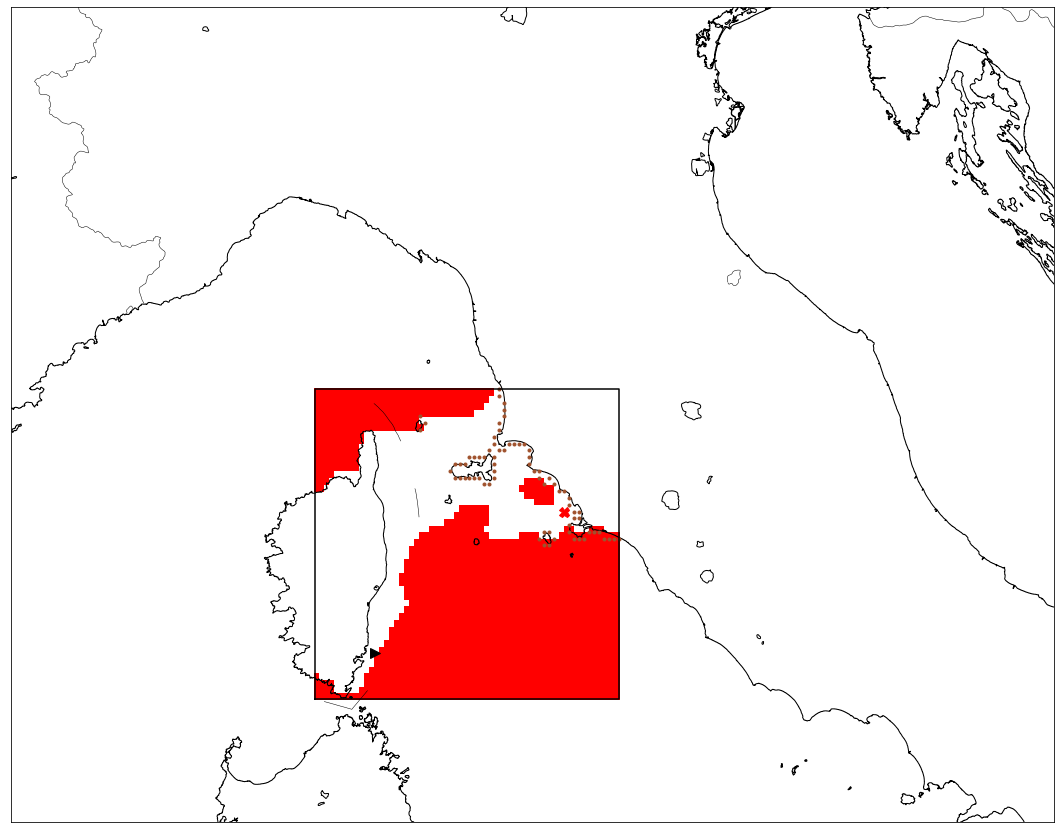

In [47]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
mp.pcolor(x, y, cost15, cmap=ListedColormap(['white', 'red']))
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [20]:
oxmeteo, oymeteo = [], []     # all meteo points
oxmeteo_, oymeteo_ = [], []   # all meteo points
x_obsm, y_obsm = [], []       # contour meteo points
image = np.zeros((47, 62))
for k in np.arange(0,47,1):
    for j in np.arange(0,62,1):
        if contour15[k][j]:
            x_obsm.append(lons.values[j])
            y_obsm.append(lats.values[k])
#             if lons.values[j] > 9.6: 
#                 image[k][j] = 1


# convex_image = convex_hull_object(image)    
# convex_cont_image = np.logical_xor(convex_image,binary_erosion(convex_image))
# for k in np.arange(0,47,1):
#     for j in np.arange(0,62,1):
#         if convex_image[k][j]:
#             oxmeteo.append(lons.values[j])
#             oymeteo.append(lats.values[k])
#         if convex_cont_image[k][j]:  
#             x_obsm.append(lons.values[j])
#             y_obsm.append(lats.values[k])
            
x_obsm_, y_obsm_ = mp(x_obsm, y_obsm)       # meteo contour points
                
            
oxmeteo_, oymeteo_ = mp(oxmeteo, oymeteo)

NameError: name 'convex_image' is not defined

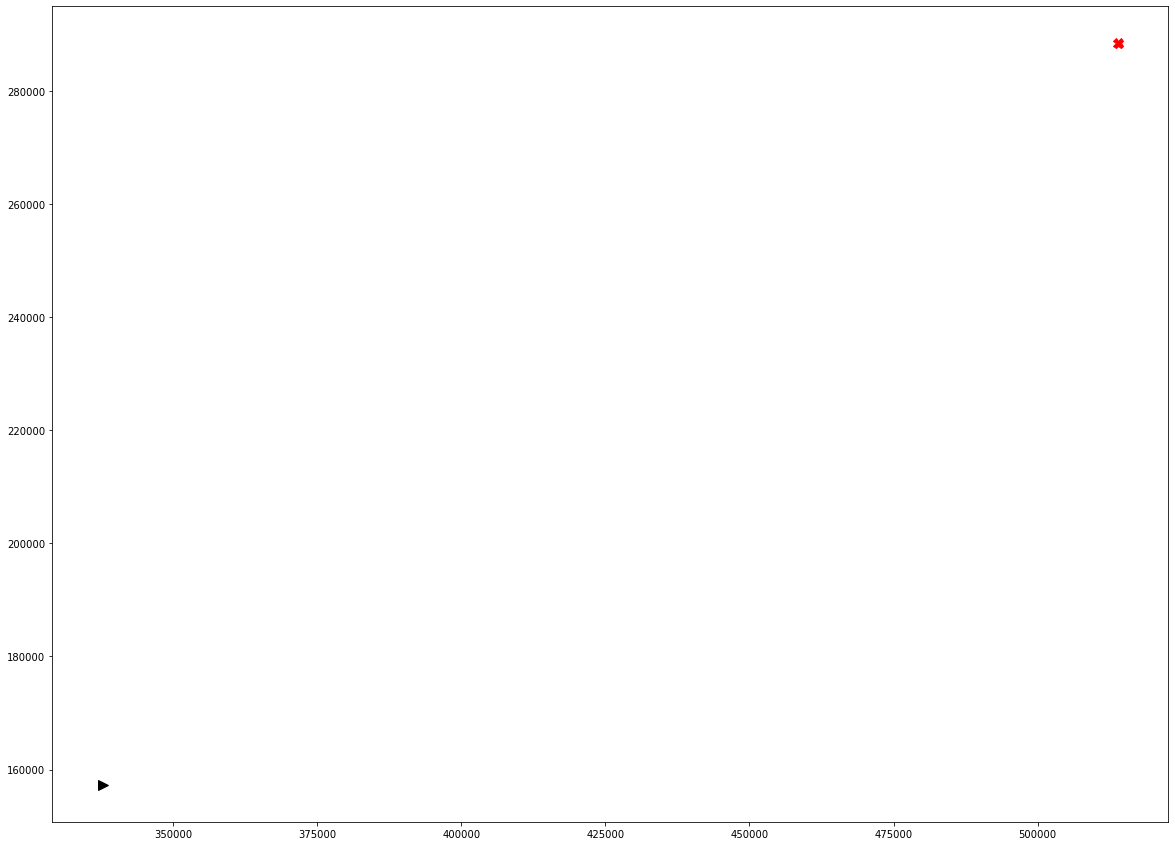

In [17]:
plt.figure(1, figsize=(20, 15))
lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp(lon, lat)
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
mp.pcolor(x, y, convex_image, cmap=ListedColormap(['white', 'red']))
plt.plot(x_obsm_, y_obsm_, '.', color="sienna")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()


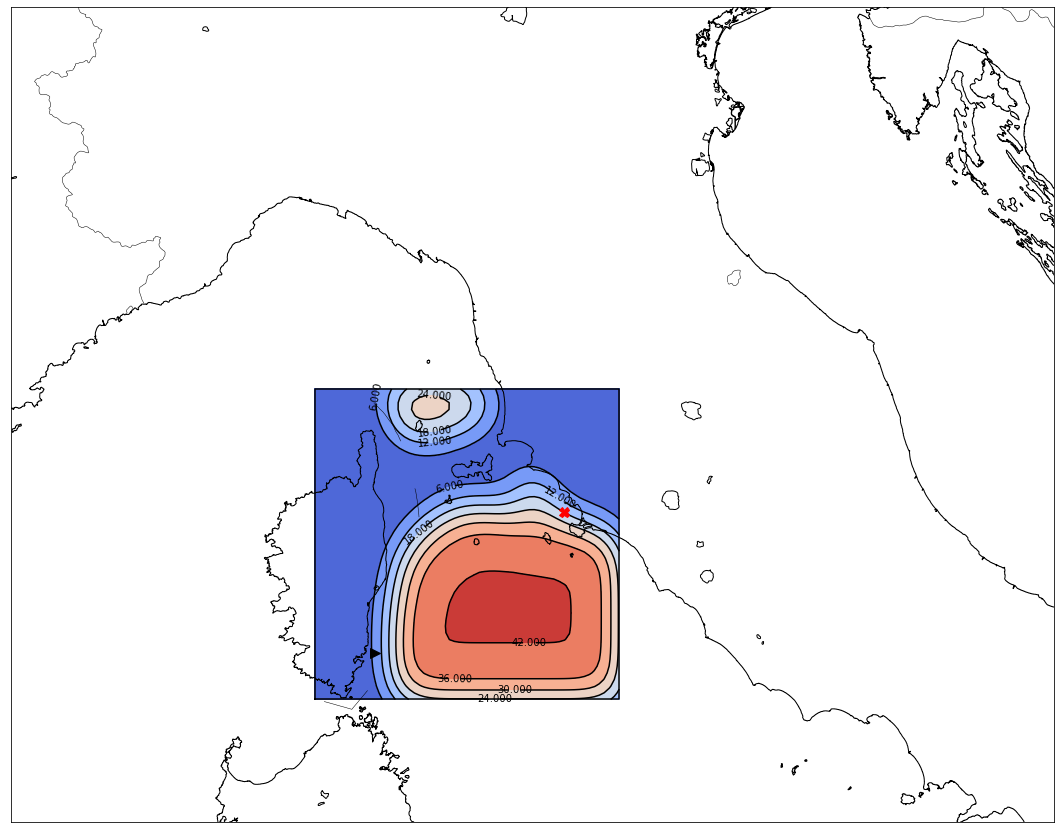

In [35]:
ux = xspace
uy = yspace
uxs, uys = np.meshgrid(ux, uy)
uxs_, uys_ = mp(uxs,uys)
f = []

positions = np.vstack([uxs.ravel(), uys.ravel()])
values = np.vstack([oxmeteo, oymeteo])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, uxs.shape)

f_tot = f*100
    
plt.figure(1, figsize=(20, 15))
ax3 = plt.axes()
ax3.contourf(uxs_, uys_, f_tot, cmap='coolwarm')
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
cset = ax3.contour(uxs_, uys_, f_tot, colors='k')
ax3.clabel(cset, inline=1, fontsize=10)
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [176]:
OSCILLATIONS_DETECTION_LENGTH  = 5
sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # 50
gy = yspace[28]   # 28
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

start = (sx, sy)
goal = (gx, gy)
grid_size = 0.04166
q_g = grid_size*5
k_att = 1

xw = 62
yw = 47
print("x_width:", xw)
print("y_width:", yw)

robot_radius = grid_size
ox = x_obsl
oy = y_obsl

x_width: 62
y_width: 47


In [163]:
# calc each potential
def comb_attractive_potential(x, y, gp, q_g):
    d_g = np.sqrt((x - gp[0]) ** 2 + (y - gp[1]) ** 2)
    if d_g <= grid_size:
        d_g = grid_size
    if d_g <= q_g:
        att_pot = 0.5 * k_att * d_g ** 2
    else:
        att_pot = q_g * k_att * d_g - 0.5 * k_att * q_g ** 2
    return att_pot

def calc_repulsive_potential(x, y, ox, oy, rr):
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        if dq <= grid_size/2:
            dq = grid_size/2

        return 0.5 * 10 * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0
    
    
pmap = [[0.0 for i in range(xw)] for i in range(yw)]

for ix in range(xw):
    x = ix * grid_size + xspace[0]
    for iy in range(yw):
        y = iy * grid_size + yspace[0]
        ug = comb_attractive_potential(x, y, goal, q_g)
#             uo = calc_repulsive_potential(x, y, ox, oy, robot_radius)
#             uo_land = calc_repulsive_potential(x, y, x_obsl, y_obsl, robot_radius)/1e2
        uf = ug*300
        pmap[iy][ix] = uf
plot_map1 = f_tot + np.array(pmap)

<ipython-input-164-0d2e82a7b58f>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs_, uys_, plot_map1, cmap=cm.YlOrBr)


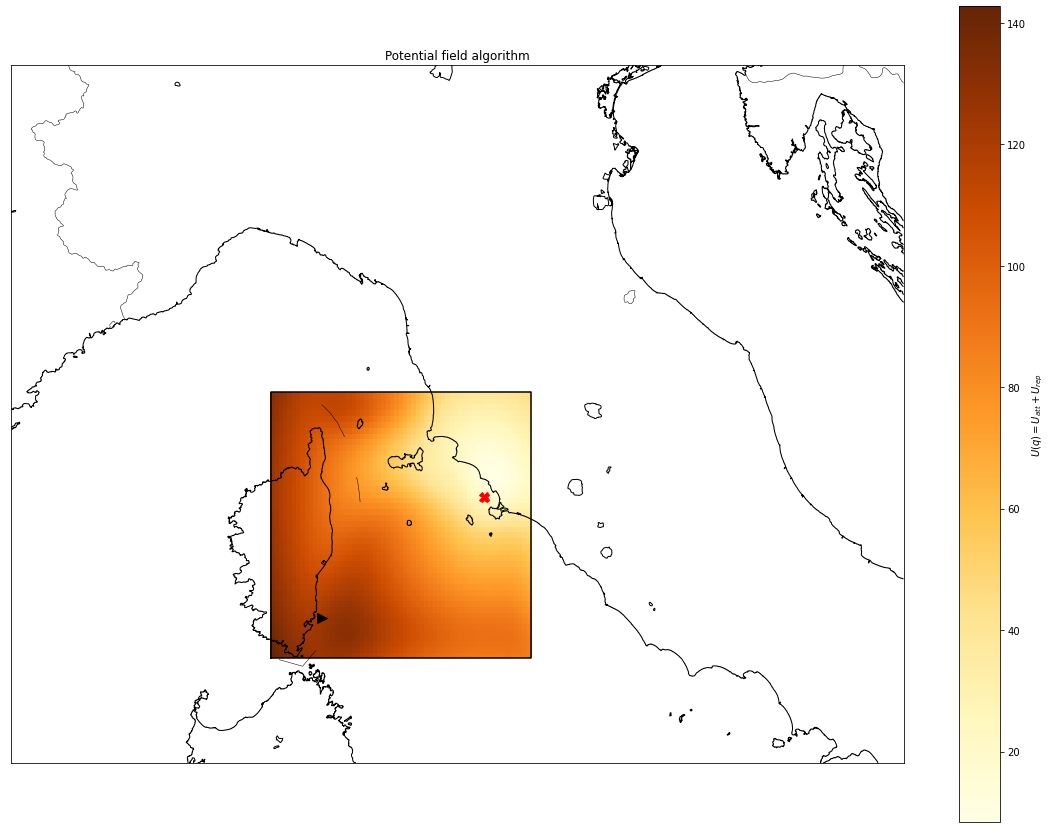

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
plt.pcolor(uxs_, uys_, plot_map1, cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [165]:
def calc_dist_from_start(x, y, s):
    a1 = mp(s[0], s[1], inverse=True)
    b1 = mp(x, y, inverse=True)
    
    return distance(lonlat(*a1), lonlat(*b1)).m

def get_motion_model():
    motion = [[1, 0],
              [0, 1],
              [-1, 0],
              [0, -1],
              [-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]]

    return motion


def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False


def potential_field_planning(s, g, reso, rr, xm, ym, pmap):
    d = np.hypot(s[0] - g[0], s[1] - g[1])
    ix = round((s[0] - xm) / reso)
    iy = round((s[1] - ym) / reso)
    gix = round((g[0] - xm) / reso)
    giy = round((g[1] - ym) / reso)

    rx, ry = [s[0]], [s[1]]
    motion = get_motion_model()
    previous_ids = deque()
    
    while d >= reso:
        minp = float("inf")
        minix, miniy = -1, -1
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if iny >= len(pmap) or inx >= len(pmap[0]) or inx < 0 or iny < 0:
                p = float("inf")  # outside area
                print("outside potential!")
            else:
                p = pmap[iny][inx]
            if minp > p:
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        xp = ix * reso + xm
        yp = iy * reso + ym
        d = np.hypot(g[0] - xp, g[1] - yp)
        rx.append(xp)
        ry.append(yp)

        if (oscillations_detection(previous_ids, ix, iy)):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            break
    
    distance = calc_dist_from_start(xp, yp, s)
        
    if d < grid_size:
        print("The robot is arrived at the final point!")
    else:
        print("The robot got lost!")

    return rx, ry, d, distance

In [166]:
d = np.hypot(start[0] - goal[0], start[1] - goal[1])
print("Distance from start to goal is: " + str(d))

dist_tot = 0
k = 1
start_time = time.time()
path_x, path_y, d_update, new_distance = potential_field_planning(start, goal, grid_size, robot_radius, xspace[0], yspace[0], plot_map1)
print("Computational time is {} seconds".format(round(time.time() - start_time,5)))

Distance from start to goal is: 1.809025
Oscillation detected at (52,31)!
The robot got lost!
Computational time is 0.00488 seconds


<ipython-input-167-712da0689c6f>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs_, uys_, plot_map1, cmap=cm.YlOrBr)


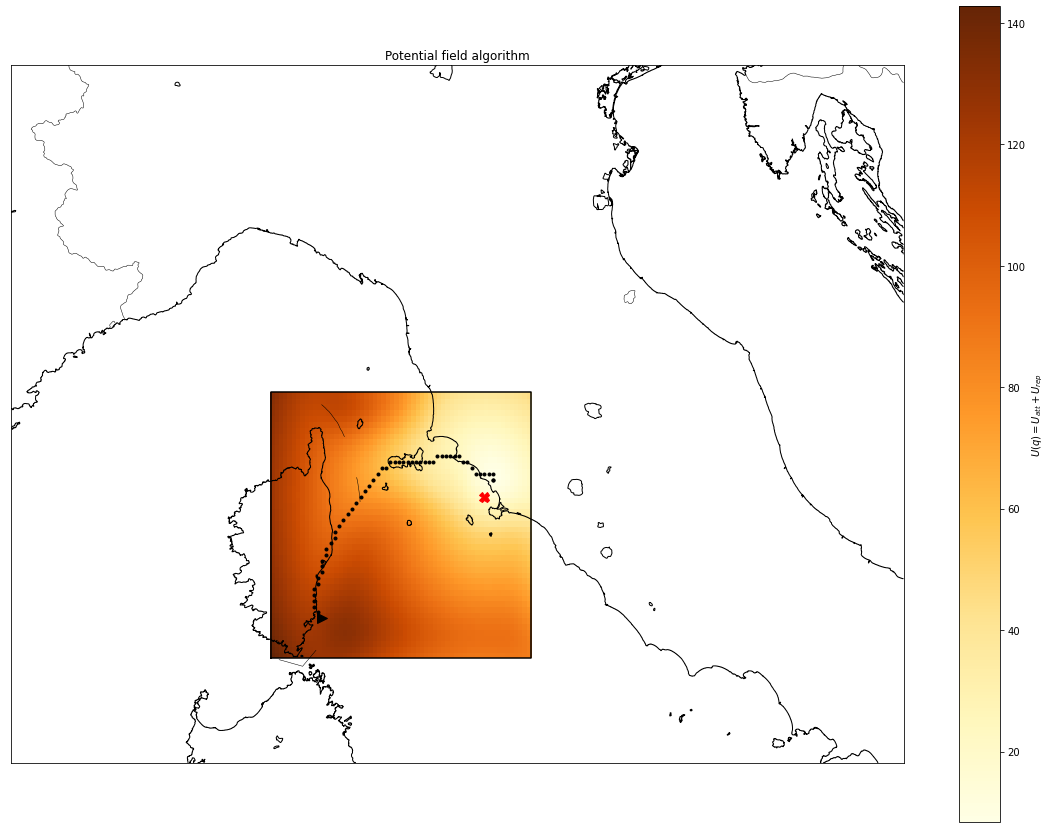

In [167]:
path_x_, path_y_ = mp(path_x, path_y)
fig1 = plt.figure(1, figsize=(20, 15))
ax = fig1.add_subplot()
plt.pcolor(uxs_, uys_, plot_map1, cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot(path_x_, path_y_, '.k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

# Limit cycle APF

In [806]:
import math
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import time


class Vector2d:
    def __init__(self, x, y):
        self.deltaX = x
        self.deltaY = y
        self.length = -1
        self.direction = [0, 0]
        self.vector2d_share()

    def vector2d_share(self):
        if type(self.deltaX) == type(list()) and type(self.deltaY) == type(list()):
            deltaX, deltaY = self.deltaX, self.deltaY
            self.deltaX = deltaY[0] - deltaX[0]
            self.deltaY = deltaY[1] - deltaX[1]
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None
        else:
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None

    def __add__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX += other.deltaX
        vec.deltaY += other.deltaY
        vec.vector2d_share()
        return vec

    def __sub__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX -= other.deltaX
        vec.deltaY -= other.deltaY
        vec.vector2d_share()
        return vec

    def __mul__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX *= other
        vec.deltaY *= other
        vec.vector2d_share()
        return vec

    def __truediv__(self, other):
        return self.__mul__(1.0 / other)

    def __repr__(self):
        return 'Vector deltaX:{}, deltaY:{}, length:{}, direction:{}'.format(self.deltaX, self.deltaY, self.length,
                                                                             self.direction)


class APF:

    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        """
        :param start: 起点
        :param goal: 终点
        :param obstacles: 障碍物列表，每个元素为Vector2d对象
        :param k_att: 引力系数
        :param k_rep: 斥力系数
        :param rr: 斥力作用范围
        :param step_size: 步长
        :param max_iters: 最大迭代次数
        :param goal_threshold: 离目标点小于此值即认为到达目标点
        :param is_plot: 是否绘图
        """
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threshold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01
    def attractive(self):
        att = (self.goal - self.current_pos) * self.k_att  # conical potential
        return att

    def repulsion(self):
        rep = Vector2d(0, 0)
        for obstacle in self.obstacles:
            # obstacle = Vector2d(0, 0)
            t_vec = self.current_pos - obstacle
            if t_vec.length > self.rr:
                pass
            else:
                rep += Vector2d(t_vec.direction[0], t_vec.direction[1]) * self.k_rep * (
                        1.0 / t_vec.length - 1.0 / self.rr) / (t_vec.length ** 2)  # 方向由障碍物指向机器人
        return rep

    def path_plan(self):
        while self.iters < self.max_iters and (self.current_pos - self.goal).length > self.goal_threshold:
            
            f_vec = self.attractive() + self.repulsion()
            self.current_pos += Vector2d(f_vec.direction[0], f_vec.direction[1]) * self.step_size
            self.iters += 1
            self.path.append([self.current_pos.deltaX, self.current_pos.deltaY])
#             print(self.current_pos.deltaX,self.current_pos.deltaY)
            if self.is_plot:
                plt.plot(self.current_pos.deltaX, self.current_pos.deltaY, '.b')
                plt.pause(self.delta_t)
        if (self.current_pos - self.goal).length <= self.goal_threshold:
            self.is_path_plan_success = True

In [807]:
def check_vec_angle(v1: Vector2d, v2: Vector2d):
    v1_v2 = v1.deltaX * v2.deltaX + v1.deltaY * v2.deltaY
    angle = math.acos(v1_v2 / (v1.length * v2.length)) * 180 / math.pi
    return angle


class APF_Improved(APF):
    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr  
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threshold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01
        
    def repulsion(self):
        """
        斥力计算, 改进斥力函数, 解决不可达问题
        :return: 斥力大小
        """
        rep = Vector2d(0, 0) 
        for obstacle in self.obstacles:
            obs_to_rob = self.current_pos - obstacle
            rob_to_goal = self.goal - self.current_pos
            obs_to_goal = self.goal - obstacle
            if obs_to_rob.length > self.rr:  
                pass
            else:

                """rep_1 = Vector2d(obs_to_rob.direction[0], obs_to_rob.direction[1]) * self.k_rep * (
                        1.0 / obs_to_rob.length - 1.0 / self.rr) / (obs_to_rob.length ** 2) * (rob_to_goal.length ** 2)
                rep_2 = Vector2d(rob_to_goal.direction[0], rob_to_goal.direction[1]) * self.k_rep * ((1.0 / obs_to_rob.length - 1.0 / self.rr) ** 2) * rob_to_goal.length
                rep +=(rep_1+rep_2)"""

                #rep += Vector2d(+obs_to_rob.direction[1], -obs_to_rob.direction[0]) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(9 - (obs_to_rob.deltaX)**2 - (obs_to_rob.deltaY)**2)
                #if obs_to_goal <
                rep = (Vector2d(obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(self.rr**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2))*50# *(1 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2)
                #if self.current_pos.deltaX < 9.5:
                #    rep = (Vector2d(-obs_to_rob.deltaY, +obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX,obs_to_rob.deltaY)*(self.rr ** 2 - obs_to_rob.deltaX ** 2 - obs_to_rob.deltaY ** 2)) * 50
        return rep

    """def repulsion(self):
        
        #斥力计算, 改进斥力函数, 解决不可达问题
        #:return: 斥力大小
        
        rep = Vector2d(0, 0) 
        for obstacle in self.obstacles:
            obs_to_rob = self.current_pos - obstacle
            rob_to_goal = self.goal - self.current_pos
            #obs_to_goal = self.goal - obstacle
            
            if obs_to_rob.length > self.rr: 
                var = False
                pass # non active
                
            else:
                obs_to_robinv = obstacle - self.current_pos
                d_pro = (np.cross(np.array([rob_to_goal.deltaX, rob_to_goal.deltaY]), np.array([obs_to_robinv.deltaX,obs_to_robinv.deltaY])) / rob_to_goal.length)
                rep = (Vector2d(obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*((self.rr)**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2))*30
                if var == False:
                    if obs_to_rob.deltaY > 0:
                        rep = (Vector2d(obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*((self.rr)**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2))*30
                    else:
                        rep = (Vector2d(-obs_to_rob.deltaY, +obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*((self.rr)**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2))*30  
                var = True
        return rep"""


In [1]:
grid_size = 0.04166
rr = grid_size*2
step_size, max_iters, goal_threshold = grid_size, 500, grid_size
step_size_ = grid_size*3

obs = []
for i in range(len(x_obsm)):
    obs.append([x_obsm[i], y_obsm[i]])
# obs.append([9.46,41.64])
# obs.append([9.46,41.5])
# obs.append([9.46,41.4])
# obs.append([9.46,41.3])
# for i in range(len(x_obsl)):
#       obs.append([x_obsl[i], y_obsl[i]])
obs_ = []
for i in range(len(x_obsm_)):
    obs_.append([x_obsm_[i], y_obsm_[i]])
for i in range(len(x_obsl_)):
    obs_.append([x_obsl_[i], y_obsl_[i]])

NameError: name 'x_obsm' is not defined

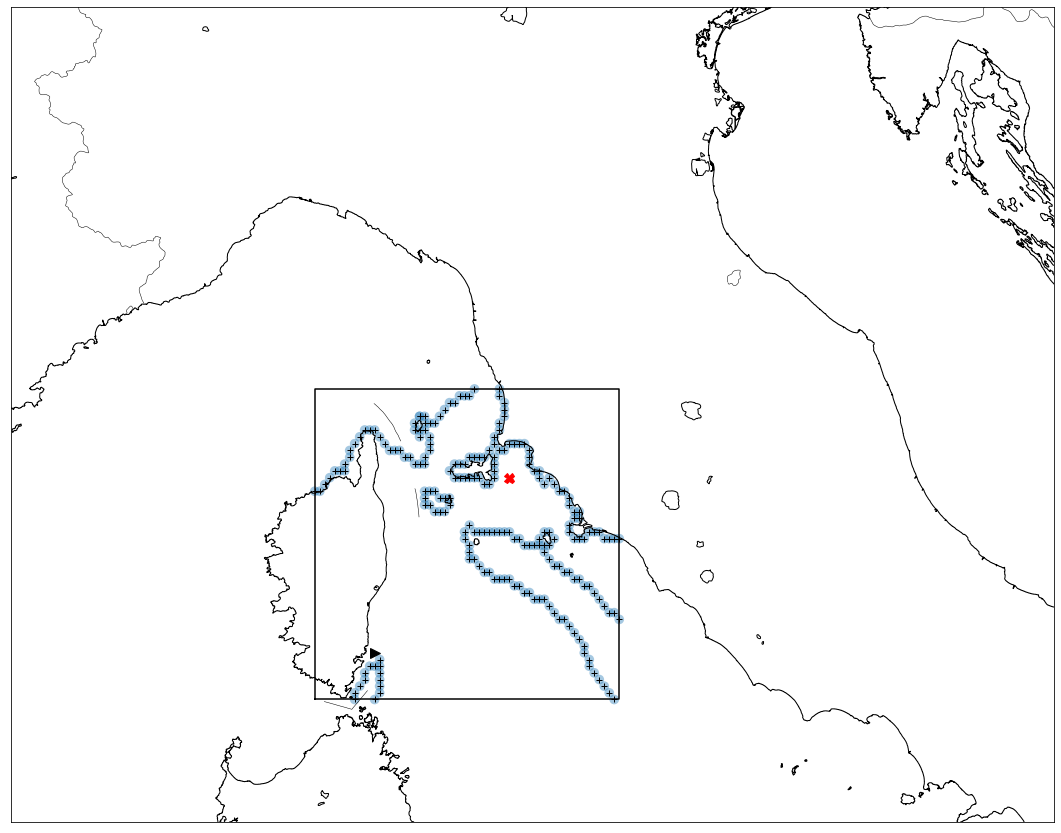

In [809]:

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp(lon, lat)
plt.plot(sx_init, sy_init, ">k", markersize=10)
for OB in obs_:
    circle = Circle(xy=(OB[0], OB[1]), radius=4500, alpha=0.4)
    ax.add_patch(circle)
    ax.plot(OB[0], OB[1], '+k')
plt.plot(gx_a, gy_a, "Xr", markersize=10)
# plt.plot(x_obsm_, y_obsm_, '.', color="dodgerblue")
# plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()


In [815]:
sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # 50
gy = yspace[28]   # 28
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

start = (sx, sy)
goal = (gx, gy)


In [816]:
start_time = time.time()
apf = APF_Improved(start, goal, obs, 1, 0.8, rr, step_size, max_iters, goal_threshold, False)
apf.path_plan()
print("Computational time is {} seconds".format(time.time() - start_time))

path = apf.path
path_ = []
i = int(step_size_ / step_size)
while i < len(path):
    path_.append(path[i])
    i += int(step_size_ / step_size)
if path_[-1] != path[-1]:  # 添加最后一个点
    path_.append(path[-1])
# print('planed path points:{}'.format(path_))
if apf.is_path_plan_success:
    print('path plan success')
else:
    print('path plan failed')

Computational time is 0.5750389099121094 seconds
path plan success


In [817]:
pathgeo = []
for i in range(len(path)):
    tempx, tempy = mp(path[i][0],path[i][1])
    pathgeo.append([tempx,tempy])
    
path_dist = 0
for i in range(len(path)-1):
    path_dist += distance(lonlat(*(path[i][0],path[i][1])), 
                          lonlat(*(path[i+1][0],path[i+1][1]))).km
print("Travel time = ", str(round(path_dist/18,4)), "hours")

Travel time =  11.427 hours


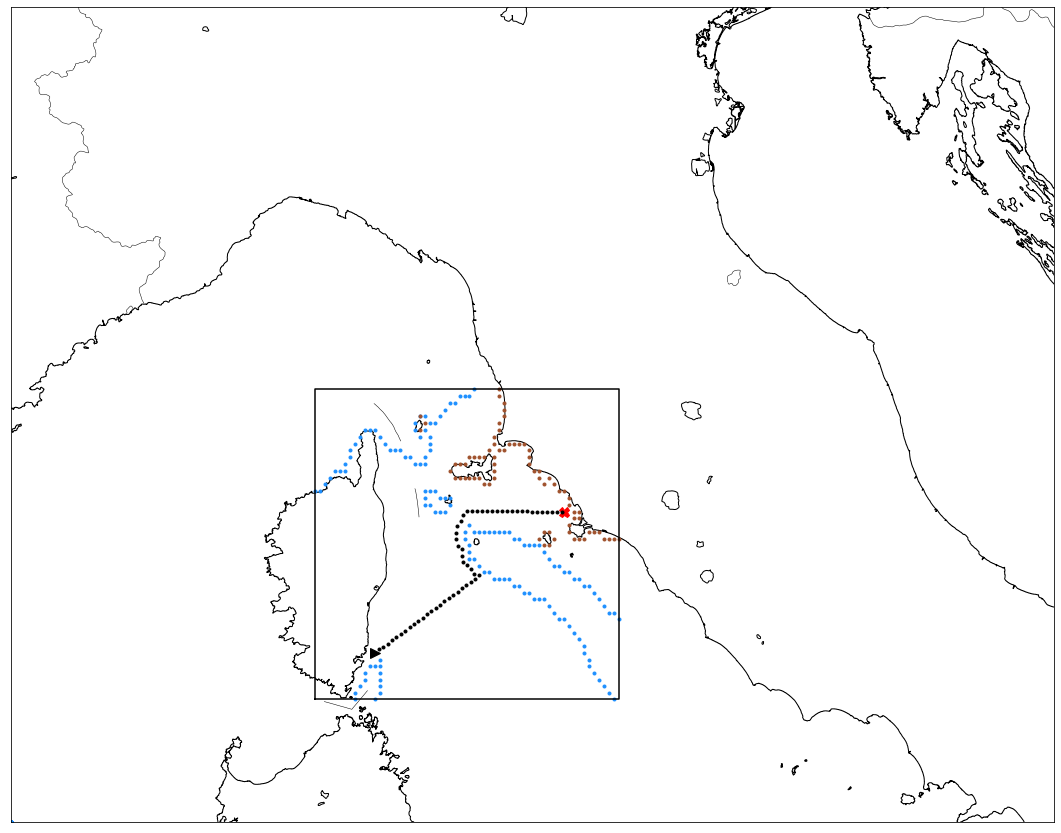

In [818]:
plt.figure(1, figsize=(20, 15))

plt.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)
plt.plot(x_obsm_, y_obsm_, '.', color="dodgerblue")
plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
for i in range(len(pathgeo)):
    plt.plot(pathgeo[i][0], pathgeo[i][1],'.', color="k")
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
for i in range(len(obs)):
    plt.plot(obs[i][0], obs[i][1],'.', color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [820]:
len(sumapf1)

12

In [29]:
# sumapf1 = [[] for i in range(5)]
# sumapf2 = [[] for i in range(5)]

In [819]:
sumapf1.append(path)

In [824]:
import pickle
file_name = "sumapf1.pkl"
open_file = open(file_name, "wb")
pickle.dump(sumapf1, open_file)
open_file.close()

# file_name = "sumapf1.pkl"
# open_file = open(file_name, "rb")
# sumapf1 = pickle.load(open_file)
# open_file.close()


In [ ]:
        """d_promin = 0
        obs_to_rob = Vector2d(0, 0)

        for obstacle in self.obstacles:
            # min_obs = Vector2d(10000,10000)
            # obstacle = Vector2d(0, 0)
            obs_to_rob = self.current_pos - obstacle   # d_r0
            obs_to_robinv = obstacle - self.current_pos
            obs_to_goal = self.goal - obstacle  # d_t0
            rob_to_goal = self.goal - self.current_pos  # l

            # d_pro
            # d_pro = (np.cross(np.array([rob_to_goal.deltaX, rob_to_goal.deltaY]), np.array([obs_to_robinv.deltaX, obs_to_robinv.deltaY])) / rob_to_goal.length)
            if min_obs.length > obs_to_robinv.length:
                min_obs = obstacle
                obs_to_rob = self.current_pos - min_obs  # d_r0
                obs_to_robinv = min_obs - self.current_pos
                obs_to_goal = self.goal - min_obs  # d_t0
                rob_to_goal = self.goal - self.current_pos  # l
                d_promin = (np.cross(np.array([rob_to_goal.deltaX, rob_to_goal.deltaY]),
                                  np.array([obs_to_robinv.deltaX, obs_to_robinv.deltaY])) / rob_to_goal.length)
                print(d_promin)
        if d_promin < rr:
            if obs_to_rob.deltaX < 0:
                if obs_to_rob.deltaY > 0:
                    rep = (Vector2d(obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX,obs_to_rob.deltaY)*
                         ((self.rr-0.04166/5)**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2)) * 30
                else:
                    rep = (Vector2d(-obs_to_rob.deltaY, obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX,obs_to_rob.deltaY) *
                           ((self.rr-0.04166/5) ** 2 - obs_to_rob.deltaX ** 2 - obs_to_rob.deltaY ** 2)) * 30

            else:
                if obs_to_rob.deltaY > 0:
                    rep = (Vector2d(obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX,obs_to_rob.deltaY) *
                           ((self.rr+0.04166/5) ** 2 - obs_to_rob.deltaX ** 2 - obs_to_rob.deltaY ** 2)) * 30
                else:
                    rep = (Vector2d(-obs_to_rob.deltaY, obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX,obs_to_rob.deltaY)*
                           ((self.rr+0.04166/5)**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2)) * 30"""